In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.inspection import permutation_importance

%matplotlib inline

In [2]:
# abrindo o arquivo de microdados do enem como dataframe usando o pandas
dadosEnem = pd.read_csv("Dados/MICRODADOS_ENEM_2019.csv", sep=";", encoding='ISO-8859-1')

In [3]:
dadosEnem.shape

(5095270, 136)

In [4]:
dadosEnem.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,...,A,A,A,C,B,A,D,A,B,A
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,...,A,A,A,B,B,A,B,A,A,A
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,...,B,A,A,D,B,B,D,A,C,B
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,...,A,A,A,C,A,A,D,A,A,A
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,...,A,A,A,B,A,A,D,A,A,A


In [5]:
dadosEnem.columns.values

array(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'CO_MUNICIPIO_NASCIMENTO',
       'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_TREINEIRO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC',
       'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA',
       'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE',
       'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR',
       'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24

In [6]:
# Selecionando as features de interesse
dadosInteresse = ['CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'NU_IDADE',
                      'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 
                      'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC', 
                      'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC',
                      'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
                      'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
                      'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                      'Q023', 'Q024', 'Q025']

In [7]:
dadosEnemInteresse = dadosEnem.filter(items=dadosInteresse)

In [8]:
# Filtrando o dataset apenas para os candidatos que estiveram presentes nas provas 
for element in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC']:
    dadosEnemInteresse = dadosEnemInteresse[dadosEnemInteresse[element]==1]

In [9]:
# Filtrando o dataset apenas para alunos que não zeraram nenhuma das provas
for element in ['NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']:
    dadosEnemInteresse = dadosEnemInteresse[dadosEnemInteresse[element]!=0]

In [10]:
# Retirando as colunas de presença do nosso modelo 
# Só iremos manter Código do Municipo, Código do Estdo, Idade, Sexo, Raça, Escola e o questionário sócioeconomico, e as notas

dadosEnemInteresse = dadosEnemInteresse.drop(columns=['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC'])

#### Tratando valores missing

In [11]:
dadosEnemInteresse.isnull().sum(axis=0).sort_values(ascending=False)

NU_NOTA_REDACAO            1
CO_MUNICIPIO_RESIDENCIA    0
Q017                       0
Q011                       0
Q012                       0
Q013                       0
Q014                       0
Q015                       0
Q016                       0
Q018                       0
Q009                       0
Q019                       0
Q020                       0
Q021                       0
Q022                       0
Q023                       0
Q024                       0
Q010                       0
Q008                       0
CO_UF_RESIDENCIA           0
NU_NOTA_MT                 0
NU_IDADE                   0
TP_SEXO                    0
TP_COR_RACA                0
TP_ESCOLA                  0
NU_NOTA_CN                 0
NU_NOTA_CH                 0
NU_NOTA_LC                 0
Q007                       0
Q001                       0
Q002                       0
Q003                       0
Q004                       0
Q005                       0
Q006          

In [12]:
# Como só temos uma linha com valor NULL em NU_NOTA_REDACAO, iremos dropa-la pois facilitará na hora de remoção dos outliers
dadosEnemInteresse = dadosEnemInteresse.dropna()

In [13]:
# Não temos mais valores nulos nas nossas features, porém algumas perguntas do questionário socioeconomico possuem a opção 
# "Não sei", esses valores serão tratados como missing data pelo nosso modelo. 


# TP_COR_RACA - 0 (Não declarado)
# TP_ESCOLA - 1 (Não respondeu)
# Q001 - Escolaridade do pai - H 
# Q002 - Escolaridade da mãe - H 
# Q003 - Profissão do pai - F
# Q004 - Profissão da mãe - F

In [14]:
# Total de registros do dataset
total = len(dadosEnemInteresse.index) 

# Total de candidatos que não sabem a escolaridade de ambos os pais
EscolaridadePaieMae = dadosEnemInteresse[(dadosEnemInteresse['Q001'] == 'H') \
                                      & (dadosEnemInteresse['Q002'] == 'H')]['Q002'].count()

EscolaridadePaieMae_Percent = round(EscolaridadePaieMae*100/total,1)


# Total de candidatos que não sabem a ocupação de ambos os pais
OcupacaoPaieMae = dadosEnemInteresse[(dadosEnemInteresse['Q003'] == 'F') \
                                      & (dadosEnemInteresse['Q004'] == 'F')]['Q003'].count()

OcupacaoPaieMae_Percent = round(OcupacaoPaieMae*100/total,1)

print('Candidatos que não sabem a escolaridade de ambos os pais: ' + 
      str(EscolaridadePaieMae) + ' - ' + str(EscolaridadePaieMae_Percent) + '%') 

print('Candidatos que não sabem a ocupação de ambos os pais ' + 
      str(OcupacaoPaieMae)  + ' - ' + str(OcupacaoPaieMae_Percent) + '%')    

Candidatos que não sabem a escolaridade de ambos os pais: 63171 - 1.8%
Candidatos que não sabem a ocupação de ambos os pais 110974 - 3.1%


In [15]:
# 1.8% dos candidatos não sabem a escolaridade de ambos os pais, então iremos então eliminar esses candidatos
# _wmd = without missing data

dadosEnemInteresse_wmd = dadosEnemInteresse[(dadosEnemInteresse['Q001'] != 'H') | (dadosEnemInteresse['Q002'] != 'H')]

In [16]:
# 3.1% dos candidatos não sabem a ocupação de ambos os pais também serão eliminados
dadosEnemInteresse_wmd = dadosEnemInteresse_wmd[(dadosEnemInteresse_wmd['Q003'] != 'F') | \
                                                (dadosEnemInteresse_wmd['Q004'] != 'F')]

#### Feature Engineering

##### 1ª Feature - Max escolaridade entre o pai e a mãe 

In [17]:
# Forte correlação visto no baseline, além de resolver o problema do missing data
# para candidatos que sabem apenas a escolaridade de um dos pais 

# Criando uma cópia do Dataframe para facilitar as manipulaçãos de feature enginnering
dadosEnemInteresse_FE = dadosEnemInteresse_wmd.copy()

In [18]:
# Substituindo os dados da Q001 por valores númericos
dadosEnemInteresse_FE['Q001'] = dadosEnemInteresse_FE['Q001'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3,
                                                                   'E': 4, 'F': 5, 'G': 6, 'H':-1})

# Substituindo os dados da Q002 por valores númericos
dadosEnemInteresse_FE['Q002'] = dadosEnemInteresse_FE['Q002'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3,
                                                                   'E': 4, 'F': 5, 'G': 6, 'H':-1})

In [19]:
# Selecionando a maior escolaridade entre as features selecionadas
dadosEnemInteresse_FE['MAX_ESCOLARIDADE_PAIS'] = dadosEnemInteresse_FE[['Q001','Q002']].max(axis=1)

In [20]:
# Dropando as duas colunas que dizem respeito a escolaridade
dadosEnemInteresse_FE.drop(['Q001', 'Q002'], axis=1, inplace=True)

##### 2ª Feature - Max ocupação entre o pai e mãe

In [21]:
# Forte correlação visto no baseline, além de resolver o problema do missing data
# para candidatos que sabem apenas a ocupação de um dos pais 

In [22]:
# Substituindo os dados da Q003 por valores númericos
dadosEnemInteresse_FE['Q003'] = dadosEnemInteresse_FE['Q003'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3,
                                                                   'E': 4, 'F': -1})

# Substituindo os dados da Q004 por valores númericos
dadosEnemInteresse_FE['Q004'] = dadosEnemInteresse_FE['Q004'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3,
                                                                   'E': 4, 'F': -1})

In [23]:
# Selecionando a maior escolaridade entre as features selecionadas
dadosEnemInteresse_FE['MAX_OCUPACAO_PAIS'] = dadosEnemInteresse_FE[['Q003','Q004']].max(axis=1)

In [24]:
# Dropando as duas colunas que dizem respeito a ocupação dos pais
dadosEnemInteresse_FE.drop(['Q003', 'Q004'], axis=1, inplace=True)

In [25]:
dadosEnemInteresse_FE.head()

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_REDACAO,NU_NOTA_MT,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MAX_ESCOLARIDADE_PAIS,MAX_OCUPACAO_PAIS
0,1506807,15,21,M,3,1,472.9,466.0,780.0,369.1,...,A,C,B,A,D,A,B,A,4,0
1,1504059,15,16,F,3,1,358.9,495.4,600.0,416.5,...,A,B,B,A,B,A,A,A,4,0
2,1505502,15,18,F,1,3,574.2,538.7,640.0,571.5,...,A,D,B,B,D,A,C,B,4,3
5,1500800,15,31,M,1,1,522.0,592.6,580.0,605.3,...,A,B,A,A,D,A,A,A,2,3
6,1504208,15,30,F,3,1,407.4,480.1,360.0,581.5,...,A,B,A,A,B,A,A,B,1,0


##### 3ª Feature - Renda por morador

In [26]:
# Q005 indica a quantidade de pessoas que moram na mesma casa que o candidato
# Q006 indica a renda mensal da familia

# A - Nenhuma renda.
# B - R$ 998,00.
# C - R$ 998,01 até R$ 1.497,00.
# D - R$ 1.497,01 até R$ 1.996,00.
# E - R$ 1.996,01 até R$ 2.495,00.
# F - R$ 2.495,01 até R$ 2.994,00.
# G - R$ 2.994,01 até R$ 3.992,00.
# H - R$ 3.992,01 até R$ 4.990,00.
# I - R$ 4.990,01 até R$ 5.988,00.
# J - R$ 5.988,01 até R$ 6.986,00.
# K - R$ 6.986,01 até R$ 7.984,00.
# L - R$ 7.984,01 até R$ 8.982,00.
# M - R$ 8.982,01 até R$ 9.980,00.
# N - R$ 9.980,01 até R$ 11.976,00.
# O - R$ 11.976,01 até R$ 14.970,00.
# P - R$ 14.970,01 até R$ 19.960,00.
# Q - Mais de R$ 19.960,00

In [27]:
# Substituindo os dados da Q006 por valores númericos
dadosEnemInteresse_FE['Q006'] = dadosEnemInteresse_FE['Q006'].map({'A': 0, 
                                                                   'B': 998, 
                                                                   'C': 999, 
                                                                   'D': 1498,
                                                                   'E': 1997, 
                                                                   'F': 2496,
                                                                   'G': 2995,
                                                                   'H': 3992,
                                                                   'I': 4991,
                                                                   'J': 5989,
                                                                   'K': 6987,
                                                                   'L': 7985,
                                                                   'M': 8983,
                                                                   'N': 9981,
                                                                   'O': 11977,
                                                                   'P': 14971,
                                                                   'Q': 19960,
                                                                  })

In [28]:
# Criando a nova de feature renda por morador 
dadosEnemInteresse_FE['RENDA_MORADOR'] = dadosEnemInteresse_FE['Q006']/dadosEnemInteresse_FE['Q005']

In [29]:
# Como as features utilizadas não possuem dados missing, elas não serão excluidas do modelo

In [30]:
dadosEnemInteresse_FE.head()

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_REDACAO,NU_NOTA_MT,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MAX_ESCOLARIDADE_PAIS,MAX_OCUPACAO_PAIS,RENDA_MORADOR
0,1506807,15,21,M,3,1,472.9,466.0,780.0,369.1,...,C,B,A,D,A,B,A,4,0,142.571429
1,1504059,15,16,F,3,1,358.9,495.4,600.0,416.5,...,B,B,A,B,A,A,A,4,0,199.600000
2,1505502,15,18,F,1,3,574.2,538.7,640.0,571.5,...,D,B,B,D,A,C,B,4,3,333.000000
5,1500800,15,31,M,1,1,522.0,592.6,580.0,605.3,...,B,A,A,D,A,A,A,2,3,199.800000
6,1504208,15,30,F,3,1,407.4,480.1,360.0,581.5,...,B,A,A,B,A,A,B,1,0,249.750000


#### Analise de outliers

In [31]:
# Os outliers são dados que se diferenciam drasticamente de todos os outros, 
# são pontos fora da curva normal (o que é curva normal?). 
# Em outras palavras, um outlier é um valor que foge da normalidade e que pode (e provavelmente irá) 
# causar anomalias nos resultados obtidos por meio de algoritmos e sistemas de análise.

In [32]:
# wo = without outliers
dadosEnemInteresse_wo = dadosEnemInteresse_FE.copy()

In [33]:
dadosEnemInteresse_wo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436244 entries, 0 to 5095269
Data columns (total 35 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CO_MUNICIPIO_RESIDENCIA  int64  
 1   CO_UF_RESIDENCIA         int64  
 2   NU_IDADE                 int64  
 3   TP_SEXO                  object 
 4   TP_COR_RACA              int64  
 5   TP_ESCOLA                int64  
 6   NU_NOTA_CN               float64
 7   NU_NOTA_CH               float64
 8   NU_NOTA_REDACAO          float64
 9   NU_NOTA_MT               float64
 10  NU_NOTA_LC               float64
 11  Q005                     int64  
 12  Q006                     int64  
 13  Q007                     object 
 14  Q008                     object 
 15  Q009                     object 
 16  Q010                     object 
 17  Q011                     object 
 18  Q012                     object 
 19  Q013                     object 
 20  Q014                     object 
 21  Q015    

In [34]:
dadosEnemInteresse_wo.columns.values

array(['CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC', 'Q005', 'Q006',
       'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
       'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
       'Q023', 'Q024', 'Q025', 'MAX_ESCOLARIDADE_PAIS',
       'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR'], dtype=object)

In [35]:
features = ['CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_ESCOLA',
            'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC',
            'Q005', 'Q006', 'MAX_ESCOLARIDADE_PAIS', 'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR'] # Apenas as features numéricas

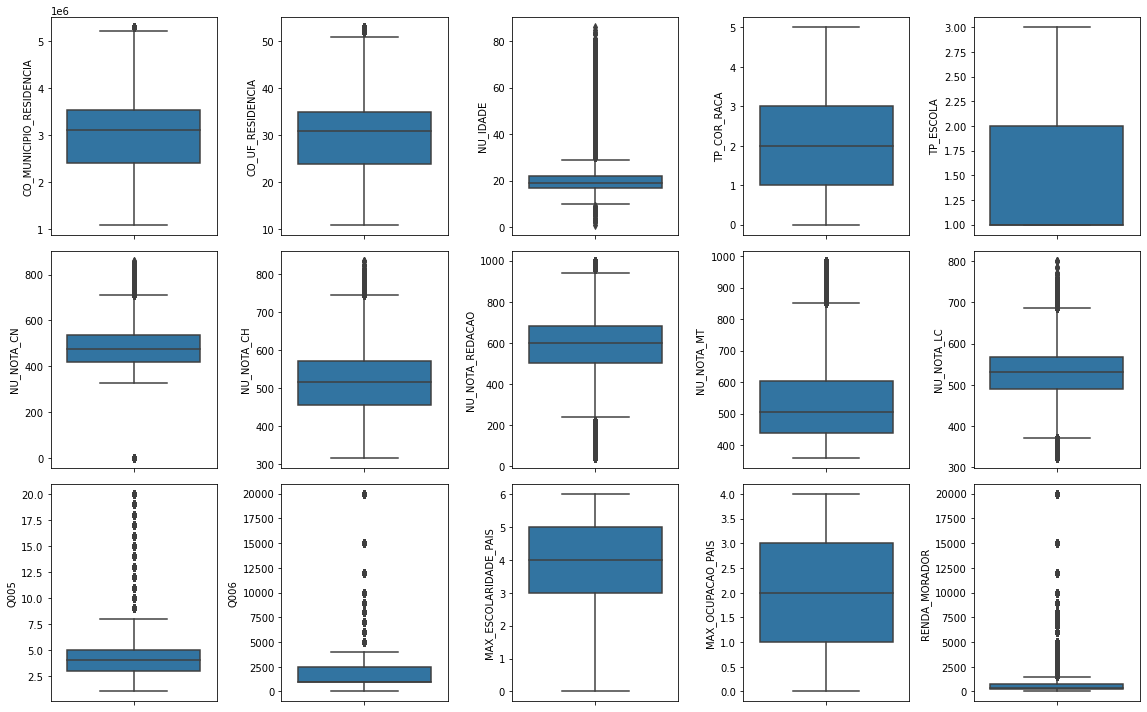

In [36]:
# Visualizando os outliers de forma gráfica
plt.figure(figsize=(16,10))

for i,col in enumerate(features):    
    plt.subplot(3,5,i + 1)
    sns.boxplot(y=col, data=dadosEnemInteresse_wo)

plt.tight_layout()

plt.show()

In [37]:
# Algumas colunas estão com o tipo Inteiro, mas não faz sentido remover o outliers dessas features
# por isso iremos passa-lás para o tipo String

dadosEnemInteresse_wo['CO_UF_RESIDENCIA'] = dadosEnemInteresse_wo['CO_UF_RESIDENCIA'].astype(str)
dadosEnemInteresse_wo['CO_MUNICIPIO_RESIDENCIA'] = dadosEnemInteresse_wo['CO_MUNICIPIO_RESIDENCIA'].astype(str)
dadosEnemInteresse_wo['TP_COR_RACA'] = dadosEnemInteresse_wo['TP_COR_RACA'].astype(str)
dadosEnemInteresse_wo['TP_ESCOLA'] = dadosEnemInteresse_wo['TP_ESCOLA'].astype(str)

In [38]:
# update all the outliers in all the columns in a dataset with the interquartile range

def fixoutliers(x):

    ##Get all the column name from the input dataframe x
    xColumnNames=x.columns
    #print(xColumnNames)
    #for j in df2ColumnNames:

    for j in xColumnNames:
        try:
            #print("colnames ",j)
            xy=x[j]    
            mydata=pd.DataFrame()
            #print(xy)
            updated=[]
            Q1,Q3=np.percentile(xy,[25,75])
            IQR=Q3-Q1
            minimum=Q1-1.5*IQR
            maximum=Q3+1.5*IQR
            for i in xy:
                if(i>maximum):
                    #print("Entering maxim")
                    i=maximum
                    updated.append(i)
                elif(i<minimum):
                    #print("enterinf minimum")
                    i=minimum
                    updated.append(i)
                else:
                    updated.append(i)
            x[j]=updated
        except:
            continue
    return x

In [39]:
fixoutliers(dadosEnemInteresse_wo)

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_REDACAO,NU_NOTA_MT,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MAX_ESCOLARIDADE_PAIS,MAX_OCUPACAO_PAIS,RENDA_MORADOR
0,1506807,15,21.0,M,3,1,472.9,466.0,780.0,369.1,...,C,B,A,D,A,B,A,4,0,142.571429
1,1504059,15,16.0,F,3,1,358.9,495.4,600.0,416.5,...,B,B,A,B,A,A,A,4,0,199.600000
2,1505502,15,18.0,F,1,3,574.2,538.7,640.0,571.5,...,D,B,B,D,A,C,B,4,3,333.000000
5,1500800,15,29.5,M,1,1,522.0,592.6,580.0,605.3,...,B,A,A,D,A,A,A,2,3,199.800000
6,1504208,15,29.5,F,3,1,407.4,480.1,360.0,581.5,...,B,A,A,B,A,A,B,1,0,249.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095261,2927408,29,27.0,F,2,1,486.7,457.8,280.0,488.5,...,B,A,B,C,A,B,B,3,1,332.666667
5095262,2928604,29,22.0,F,2,1,454.2,542.7,400.0,504.7,...,B,B,A,E,B,B,B,4,2,142.714286
5095263,2906808,29,29.5,M,3,1,450.4,469.0,580.0,552.0,...,B,B,A,C,A,B,B,1,1,499.500000
5095268,2927408,29,16.0,M,1,1,458.8,380.6,800.0,396.7,...,B,B,A,C,A,B,B,6,4,831.833333


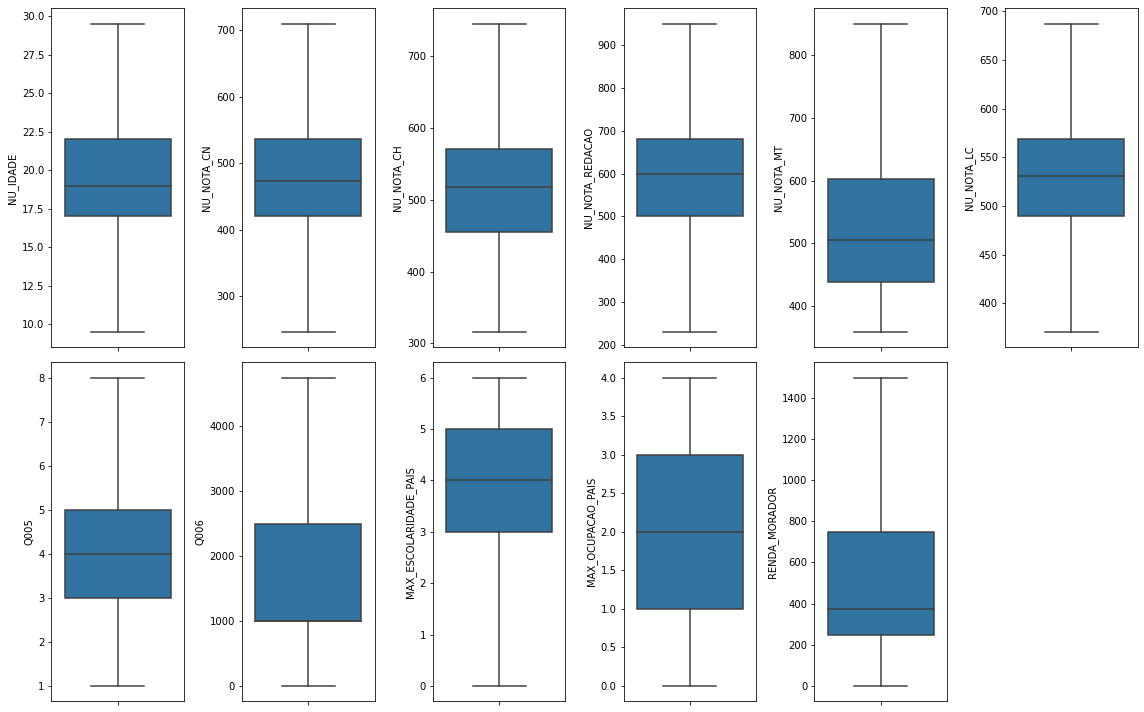

In [40]:
features = ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC',
            'Q005', 'Q006', 'MAX_ESCOLARIDADE_PAIS', 'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR'] # Apenas as features numéricas

plt.figure(figsize=(16,10))

for i,col in enumerate(features):    
    plt.subplot(2,6,i + 1)
    sns.boxplot(y=col, data=dadosEnemInteresse_wo)

plt.tight_layout()

plt.show()

In [41]:
# Redefinindo a tipagem dos dados que foi feita nos passos anteriores
dadosEnemInteresse_wo['TP_COR_RACA'] = dadosEnemInteresse_wo['TP_COR_RACA'].astype(float)
dadosEnemInteresse_wo['CO_UF_RESIDENCIA'] = dadosEnemInteresse_wo['CO_UF_RESIDENCIA'].astype(int)
dadosEnemInteresse_wo['CO_MUNICIPIO_RESIDENCIA'] = dadosEnemInteresse_wo['CO_MUNICIPIO_RESIDENCIA'].astype(int)
dadosEnemInteresse_wo['TP_ESCOLA'] = dadosEnemInteresse_wo['TP_ESCOLA'].astype(int)

#### Fim Analise Outliers

#### Mapeando os tipos de variáveis

In [42]:
dadosEnemInteresse_wo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436244 entries, 0 to 5095269
Data columns (total 35 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CO_MUNICIPIO_RESIDENCIA  int32  
 1   CO_UF_RESIDENCIA         int32  
 2   NU_IDADE                 float64
 3   TP_SEXO                  object 
 4   TP_COR_RACA              float64
 5   TP_ESCOLA                int32  
 6   NU_NOTA_CN               float64
 7   NU_NOTA_CH               float64
 8   NU_NOTA_REDACAO          float64
 9   NU_NOTA_MT               float64
 10  NU_NOTA_LC               float64
 11  Q005                     float64
 12  Q006                     float64
 13  Q007                     object 
 14  Q008                     object 
 15  Q009                     object 
 16  Q010                     object 
 17  Q011                     object 
 18  Q012                     object 
 19  Q013                     object 
 20  Q014                     object 
 21  Q015    

In [43]:
# Qualitativas
    # Nominais (Profissão, Sexo, Religião)
    # Ordinal (Escolaridade, Estágio da doença, classe social)

# Quantitativas
    # Discreta (Nº de filhos, Nº de acessos a plataforma)
    # Continua (Altura, Peso, Salário)

In [44]:
dadosEnemInteresse_wo.shape

(3436244, 35)

In [45]:
# Qualitativas Nominais (Profissão, Sexo, Religião, Estado Civil, Cor dos olhos, Presença ou Ausência)
# valores que expressam atributos, sem nenhum tipo de ordem

# One-Hot-Encoding 
# Quando não existe uma ordem pré estabelecida 
# (red, blue, green) -> (0, 0, 1), (0, 1, 0), (1, 0, 0) 

nominal_features = ['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA',   
                    'Q018', 'Q020', 'Q021', 'Q023', 'Q025']

In [46]:
# Qualitativas Ordinais (Escolaridade, Estágio da doença, classe social)
# valores que expressam atributos, porém com algum tipo de ordem, ou grau.

# Ordinal Encoding (quando existe uma ordem)
# (Ensino fundamental, Ensino Médio, Faculdade) -> (0, 1, 2)

ordinal_features = ['Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 
                    'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q019', 'Q022', 
                    'Q024']

In [47]:
numerical_features = ['CO_MUNICIPIO_RESIDENCIA','CO_UF_RESIDENCIA',
                      'NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 
                      'Q005', 'Q006', 'MAX_ESCOLARIDADE_PAIS', 'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR']

#### Criação dos pipelines que irão transformar as features

In [48]:
# Pipeline para features nominais 
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # dados Missing serão substituidos pelo mais frequente
    ('onehot', OneHotEncoder(handle_unknown='error')) # (red, blue, green) -> (0, 0, 1), (0, 1, 0), (1, 0, 0) 
])

In [49]:
# Pipeline para features ordinais
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # dados Missing serão substituidos pelo mais frequente
    ('ordinal', OrdinalEncoder(handle_unknown='error')) #(Ensino fundamental, Ensino Médio, Faculdade) -> (0, 1, 2)
])

In [50]:
# Pipeline para features numericas 
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # dados Missing serão substituidos pela mediana
])

#### Criação do pré-processador

In [51]:
preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer, numerical_features),
                    ('cat_nom', nominal_transformer, nominal_features),
                    ('ord_nom', ordinal_transformer, ordinal_features)
                ])

In [52]:
# MinMaxScaler - Normalização das features
# StandardScaler - A ideia por trás do StandardScaler é que ele transformará seus 
# dados de forma que sua distribuição tenha um valor médio 0 e desvio padrão de 1.

pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('minmaxscaler', MinMaxScaler()),
        ('stdscaler',  StandardScaler()),
        ('XGBR', XGBRegressor())
])

#### Separando os dados de treino e de teste

In [53]:
X = dadosEnemInteresse_wo.drop(['NU_NOTA_REDACAO'], axis=1)
y = dadosEnemInteresse_wo.NU_NOTA_REDACAO

In [54]:
# Separando os dados de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 0)

#### Treinando o modelo

In [ ]:
xgbr_model = pipe.fit(X_treino, y_treino)

#### Permutation Importance

In [ ]:
result = permutation_importance(pipe, X_treino, y_treino, n_repeats=10,
                                random_state=42, n_jobs=2)

In [ ]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots( figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_teste.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#### Hyperparameter optimization using RandomizedSearchCV

In [ ]:
grid_param = [
        {
             "XGBR__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "XGBR__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "XGBR__min_child_weight" : [ 1, 3, 5, 7 ],
             "XGBR__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "XGBR__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }
]

In [ ]:
random_search = RandomizedSearchCV(pipe, grid_param, n_iter=5, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=3)

In [ ]:
best_model = random_search.fit(X_treino, y_treino)

In [ ]:
best_model.best_params_

In [ ]:
best_model.best_estimator_[3]

#### Refinando o modelo

In [55]:
# Com base nos resultados obtidos através do permutation importance e na otimização dos parametros iremos refinar o nosso modelo
# e comparar com os resultados obtidos no baseline

In [56]:
# Só deixaremos as 20 features mais importante de acordo com o Permutation Importance

nominal_features_final = ['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'Q025']

ordinal_features_final = ['Q008', 'Q010', 'Q011', 'Q014', 'Q022', 'Q024']

numerical_features_final = ['CO_MUNICIPIO_RESIDENCIA', 'NU_IDADE', 'NU_NOTA_CN', 
                      'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'Q006',
                      'MAX_ESCOLARIDADE_PAIS', 'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR']

In [57]:
# Pipeline para features nominais 
nominal_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # dados Missing serão substituidos pelo mais frequente
    ('onehot', OneHotEncoder(handle_unknown='error')) # (red, blue, green) -> (0, 0, 1), (0, 1, 0), (1, 0, 0) 
])

# Pipeline para features ordinais
ordinal_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # dados Missing serão substituidos pelo mais frequente
    ('ordinal', OrdinalEncoder(handle_unknown='error')) #(Ensino fundamental, Ensino Médio, Faculdade) -> (0, 1, 2)
])

# Pipeline para features numericas 
numerical_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # dados Missing serão substituidos pela mediana
])

In [58]:
preprocessor_final = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer_final, numerical_features_final),
                    ('cat_nom', nominal_transformer_final, nominal_features_final),
                    ('ord_nom', ordinal_transformer_final, ordinal_features_final)
                ])

In [64]:
pipe_final = Pipeline(steps=[
        ('preprocessor', preprocessor_final),
        ('minmaxscaler', MinMaxScaler()),
        ('stdscaler',  StandardScaler()),
        ('XGBR', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=np.nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None))
])

In [60]:
dadosEnemInteresse_final = dadosEnemInteresse_wo.copy()

In [65]:
features_final = ['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'Q025', 
                        'Q008', 'Q010', 'Q011', 'Q014', 'Q022', 'Q024', 
                        'CO_MUNICIPIO_RESIDENCIA', 'NU_IDADE', 'NU_NOTA_CN', 
                        'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'Q006',
                        'MAX_ESCOLARIDADE_PAIS', 'MAX_OCUPACAO_PAIS', 'RENDA_MORADOR']

X_final = dadosEnemInteresse_final.filter(items=features_final)

y_final = dadosEnemInteresse_final.NU_NOTA_REDACAO

In [70]:
# Separando os dados de treino e teste
X_treino_f, X_teste_f, y_treino_f, y_teste_f = train_test_split(X_final, y_final, test_size = 0.30, random_state = 0)

In [71]:
pipe_final.fit(X_treino_f, y_treino_f)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['CO_MUNICIPIO_RESIDENCIA',
                                                   'NU_IDADE', 'NU_NOTA_CN',
                                                   'NU_NOTA_CH', 'NU_NOTA_MT',
                                                   'NU_NOTA_LC', 'Q006',
                                                   'MAX_ESCOLARIDADE_PAIS',
                                                   'MAX_OCUPACAO_PAIS',
                                                   'RENDA_MORADOR']),
                                                 ('cat_nom',
                                                  Pipeline(steps=[('imputer',
                                                                

In [74]:
values_predictions = pipe_final.predict(X_teste_f)

In [85]:
print('MAE:', mean_absolute_error(y_teste_f, values_predictions))
print('RMSE:', mean_squared_error(y_teste_f, values_predictions,  squared=False))

MAE: 87.36552373124086
RMSE: 112.22307268664092


In [77]:
pd.DataFrame({'Y_teste': y_teste_f,
            'Y_predictions': values_predictions})

,Y_teste,Y_predictions
1417878,460.0,551.491150
2417693,740.0,764.454102
2676389,640.0,743.572815
3110658,920.0,867.513306
495086,880.0,841.419617
...,...,...
1895333,580.0,469.849640
979602,560.0,494.875763
4368243,480.0,514.183105
2901276,940.0,920.269653


#### Utilizando validação cruzada para validação do modelo

In [94]:
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error']

for score in scoring:
     print (-1 * cross_val_score(pipe_final, X_final, y_final, cv=kfold, scoring=score).mean())

87.2603940788915
12569.500261530806


In [95]:
np.sqrt(12569.500261530806)

112.11378265641922